#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0+cu121
Cude is available: True
Device name: NVIDIA H100 PCIe


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [3]:
seed = 0
noise = False 
version = 1 
lr = 1e-3 
sample_size = 3000
warmup_ratio = 0.25
batch_size = 16
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/Newsreader-VariableFont_opsz,wght.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.1 + 0.3*severity_indicator[var5] + 0.35*var9

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

#### **Plot**

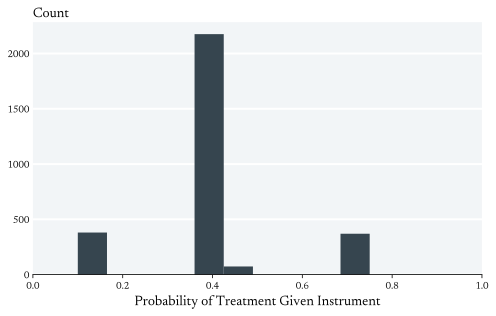

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Qlora**

In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )
additional_modules = ["attn_proj", "ff_proj"]
target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"] + additional_modules

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05, 
    target_modules='all-linear',
    bias="none",
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [12]:
model_name = "microsoft/Phi-3-mini-4k-instruct" #'meta-llama/Meta-Llama-3-70B-Instruct' #"microsoft/Phi-3-mini-4k-instruct" #meta-llama/Meta-Llama-3-8B-Instruct" 

from transformers.utils import is_flash_attn_2_available
print(is_flash_attn_2_available())
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                            device_map="auto", 
                                            quantization_config=bnb_config, 
                                            trust_remote_code=True,
                                            attn_implementation="flash_attention_2")# So we can do gradient checkpointing
model.config.use_cache = True
model.config.pretraining_tp = 1
model.generation_config.temperature = 0.001
model.enable_input_require_grads()
print(model.generation_config)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000,
  "temperature": 0.001
}

trainable params: 25,165,824 || all params: 3,846,245,376 || trainable%: 0.6543
None


#### **Tokenizer**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to left
tokenizer.padding_side = 'left'

def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Create Dataset**

In [14]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    # Initialize the dataset list
    dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        dataset.append(entry)

    dataset = Dataset.from_dict({'messages': dataset})

else:
    # Initialize the dataset list
    dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        dataset.append(entry)

    dataset = Dataset.from_dict({'messages': dataset})

#### **Token Length**

(array([119., 650., 598., 138.,  31., 303., 706., 377.,  70.,   8.]),
 array([133., 162., 191., 220., 249., 278., 307., 336., 365., 394., 423.]),
 <BarContainer object of 10 artists>)

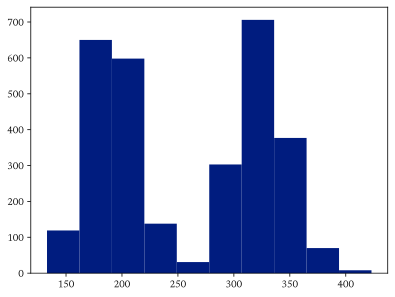

In [15]:
batched_tokens = tokenizer.apply_chat_template(dataset['messages'], tokenize=True, batched=True)
plt.hist(list(map(len, batched_tokens)))

#### **Input Type**

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

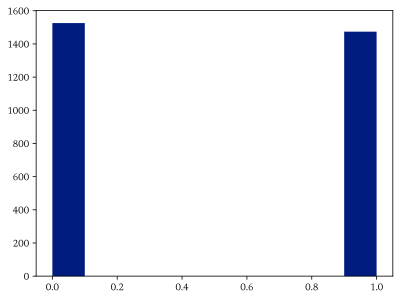

In [16]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][0]['content'] else 0 
        return example
else:
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][1]['content'] else 0 
        return example

dataset = dataset.map(get_input_id, batched=False)
plt.hist(dataset['type_indicator'])
plt.show()

In [17]:
tokens = tokenizer.apply_chat_template(dataset['messages'][0], tokenizer=False)
tokenizer.decode(tokens[-1])

'<|end|>'

#### **Output Type**

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

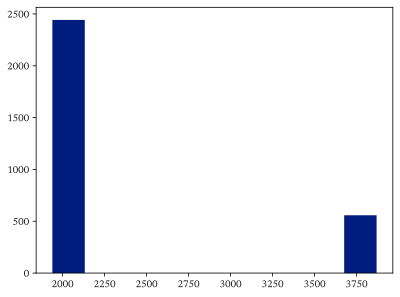

In [18]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_output_id(example):
        string = example['messages'][1]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

else:
    def get_output_id(example):
        string = example['messages'][2]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

def get_ys_id(example):
    example['yes_token'] = tokenizer.encode('Yes', add_special_tokens=False)[0] 
    return example

def get_instrument(example):
    string = example['messages'][2]['content']
    example['instrument'] = 1 if 'The tenant has access to a free lawyer.' in string else 0 

dataset = dataset.map(get_output_id, batched=False)
dataset = dataset.map(get_ys_id, batched=False)
plt.hist(dataset['target_token'])
plt.show()

#### **Data Loaders**

In [19]:
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

#### **Optimizer**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [21]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [22]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=2)

print(yuri.verbose)
early_stopping = EarlyStopping(patience)

False


#### **Training**

In [23]:
evaluation_losses = [yuri.evaluate(test_loader)[1]]
training_losses = [yuri.evaluate(train_loader)[1]]
lr_history = [yuri.optimizer.state_dict()['param_groups'][0]['lr']]
#recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')  #,  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss[1])
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss[1])
    #recall = yuri.compute_recall(test_loader)
    #recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss[1]:.4f}, Val Loss: {val_loss[1]:.4f}')# , rYes: {recall[1]:.3f}')

        # Call early stopping
    early_stopping(val_loss[1], model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

yuri.model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 23, Train Loss: 0.2970, Val Loss: 0.3274:  73%|███████▎  | 22/30 [52:20<19:01, 142.75s/it]


***Early stopping***
Min Validation Loss: 12
Current Epoch: 22


<All keys matched successfully>

#### **Losses**

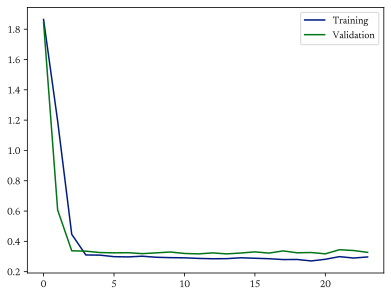

In [24]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

In [25]:
# for batch in train_loader:
#     input_ids, logits, type_indicator, target_token = yuri.process_batch(batch, 'yes_token')
#     loss, log_prob_target = yuri.compute_loss(input_ids, logits, type_indicator, target_token)
#     print(target_token)
#     print(tokenizer.decode(target_token))
#     generated_ids = yuri.model.generate(
#                         input_ids=input_ids[:,:-2],
#                         max_new_tokens=2,
#                         temperature=0.001)  # Ensure temperature is set here)
#     decoded_batch_texts = yuri.tokenizer.batch_decode(generated_ids, skip_special_tokens=False)
#     print(decoded_batch_texts)
#     break



In [26]:
_, _, log_probs, indicators, target, texts = yuri.evaluate(data_loader=test_loader, token_type='yes_token', return_decoded_text=True, max_new_tokens=2)


In [27]:
x = tokenizer.apply_chat_template(dataset['messages'][1], tokenize=True, skip_special_tokens=False)
tokenizer.decode(x[-2])

'No'

In [28]:
for i, (j, k, l) in enumerate(zip(log_probs, target, texts)):
    print(f"Target : {k}, {torch.exp(j):.4f}")
    display(to_markdown(l))
    if i > 10:
        break

Target : No, 0.3344


> <|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their early-40s who is currently late on rent for $984. They have been diagnosed with Alzheimer's disease and other dementias, which have made managing their finances and daily responsibilities increasingly challenging. The tenant lives in a small apartment complex, where they have resided for the past 24 months. They have a cat, which provides them with companionship and comfort, but also adds to their financial burden. The tenant lives with a roommate who does not contribute to the rent, further exacerbating the financial strain. Despite these difficulties, the tenant is making an effort to learn a new language, perhaps as a way to stimulate their cognitive abilities and stay connected with the broader community. This determination to grow and adapt in the face of their health challenges is admirable, but the combination of Alzheimer's, late rent, and an unsupportive living situation paints a picture of a tenant in a precarious and vulnerable position.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.0019


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a young professional in their late 20s who has been living in a small apartment complex for the past 30 months. They are currently late on their rent of $745. The tenant has been diagnosed with Alzheimer's disease and other dementias, which have made it increasingly difficult for them to manage their daily responsibilities. They live with a roommate who contributes to the rent, providing some financial support. Despite their challenges, the tenant maintains a blog where they share their daily experiences, offering a glimpse into their life and the struggles they face with their cognitive impairments.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : Yes, 0.3240


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual with mobility impairments, living in a three-story duplex that they have occupied for the past 34 months. Despite their passion for exploring local history and landmarks, they have fallen behind on their rent, which currently stands at $1,052. The tenant lives with a beloved bird and relies on contributions from family members to help cover the rent. Their living situation, with the three-story duplex posing challenges due to their mobility issues, adds an additional layer of complexity to their financial and housing circumstances.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.0004


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 38-year-old individual with mobility impairments who has been living in a large apartment complex for 32 months. They are currently behind on their rent by $724. Despite their challenges, the tenant actively participates in local charity events, demonstrating a commitment to their community. To help cover the rent, the tenant's family contributes financially. The tenant also shares their home with a beloved bird, providing companionship and comfort during this difficult period.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : No, 0.3847


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their early 50s who is currently struggling to make their monthly rent payment of $898. They have been residing in a small apartment complex for the past 23 months and face mobility impairments that make everyday tasks challenging. Despite their circumstances, they have managed to carve out a small art studio within their modest living space, where they find solace and creative expression. The tenant shares their apartment with a roommate who contributes to the rent, but the combined income has not been sufficient to keep up with the monthly payments. As they navigate the complexities of their situation, the tenant's resilience and determination to maintain their living situation are evident.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

Target : No, 0.0006


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual with a history of traumatic brain injuries. They have been residing in a two-story duplex for the past 39 months and share the living space with a roommate who contributes to the rent. Despite their challenges, the tenant is actively engaged in learning a new language, demonstrating a commitment to personal growth. However, they are currently behind on rent, owing $717. The tenant's living situation is further complicated by the presence of a beloved pet bird, which adds to the complexity of their daily life.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : No, 0.5194


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a mid-30s individual who has been residing in a three-story duplex for the past 49 months. They are currently behind on their rent, owing $809. The tenant has been diagnosed with Alzheimer's disease and other dementias, which have made it increasingly difficult for them to manage their financial obligations. Despite their condition, they occasionally work from home, relying on the presence of a fish tank to provide a sense of calm and familiarity in their living space. Unfortunately, the tenant's family members do not contribute to the rent, leaving them to shoulder the burden alone. The combination of their health challenges, financial strain, and lack of familial support has created a complex and challenging situation for this tenant.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> Yes<|end|>

Target : No, 0.0006


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 25-year-old individual who has been living in a three-story duplex for the past 29 months. They are currently behind on their rent by $1474. The tenant has been dealing with short-term illnesses, which have affected their ability to maintain steady employment. They occasionally work from home, but their roommate, who does not contribute to the rent, has been a source of additional stress. Despite these challenges, the tenant has managed to maintain their living situation without any pets. The combination of medical issues, financial strain, and an unreliable roommate has made it difficult for the tenant to keep up with their rental obligations.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : No, 0.0000


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 32-year-old individual with Autism spectrum disorders who has been living in a two-story duplex for 15 months. They currently owe $1150 in rent. Despite the financial difficulties, the tenant takes great pride in decorating their apartment for different holidays, showcasing their creative and expressive nature. Their family contributes to the rent, providing crucial support during this challenging time. Without any pets, the tenant's focus remains on maintaining their living space and finding ways to manage their finances and responsibilities.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : No, 0.0003


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 49-year-old individual with mobility impairments, living in a large apartment complex for the past 24 months. They are currently behind on their rent by $927. Despite the challenges they face, the tenant has managed to maintain a small garden on their balcony, providing a sense of solace and connection to nature. Unfortunately, the tenant's living situation is further complicated by the presence of a roommate who does not contribute to the rent payments.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : No, 0.0000


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 37-year-old individual with mobility impairments, living in a large apartment complex for the past 24 months. They are currently behind on rent, owing $1,417. The tenant shares their home with a roommate who does not contribute to the rent payments. Despite their financial struggles, the tenant enjoys writing short stories in their free time, finding solace in the creative outlet. The presence of a beloved bird adds a touch of companionship to their daily life, providing comfort and joy amidst the challenges they face.
> 
>  Note: The tenant does not have access to a free lawyer.<|end|><|assistant|> No<|end|>

Target : Yes, 0.3071


> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|user|> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual with mobility impairments who has been living in a three-story duplex for the past 20 months. They currently owe $1,404 in rent. Despite their physical challenges, the tenant occasionally works from home, managing their responsibilities to the best of their abilities. To assist with the rent, the tenant's family contributes to the household expenses. The tenant's living situation, which includes sharing their home with a beloved dog, has been a source of stability and comfort during these challenging times.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|end|><|assistant|> No<|end|>

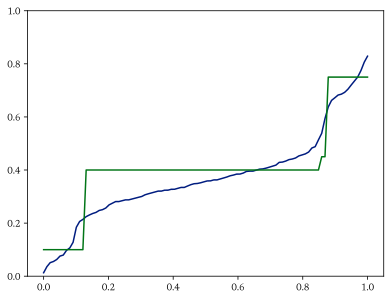

In [29]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(np.exp(log_probs)[indicators.to('cpu') == 1], qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

In [30]:
# Ensure probabilities are within (0, 1) to avoid log(0)
epsilon = 1e-15
probabilities = np.clip(df['FStage_Value'].values*df['Instrument'].values, epsilon, 1 - epsilon)

# Compute binary cross-entropy loss
bce_loss = -np.mean(df['Treatment'].values * np.log(probabilities) + (1 - df['Treatment'].values) * np.log(1 - probabilities))

print(f'Binary Cross-Entropy Loss: {bce_loss}')

Binary Cross-Entropy Loss: 0.2949498408857263


In [31]:
# Assuming you have the same tokenizer

# Convert text to token IDs
yes_token_id = tokenizer.convert_tokens_to_ids('Yes')
print(f'Token ID for "Yes" using convert_tokens_to_ids: {yes_token_id}')

# Decode the token ID back to text
decoded_text_8241 = tokenizer.decode([8241])
decoded_text_3869 = tokenizer.decode([3869])

# Print the decoded texts with their ASCII values
print(f'Decoded text for token ID 8241: {decoded_text_8241} (ASCII: {[ord(c) for c in decoded_text_8241]})')
print(f'Decoded text for token ID 3869: {decoded_text_3869} (ASCII: {[ord(c) for c in decoded_text_3869]})')

# Check the lengths of the decoded texts
print(f'Length of decoded text for token ID 8241: {len(decoded_text_8241)}')
print(f'Length of decoded text for token ID 3869: {len(decoded_text_3869)}')

# Verify if the decoded texts are identical
print(f'Decoded texts are identical: {decoded_text_8241 == decoded_text_3869}')


Token ID for "Yes" using convert_tokens_to_ids: 8241
Decoded text for token ID 8241: Yes (ASCII: [89, 101, 115])
Decoded text for token ID 3869: Yes (ASCII: [89, 101, 115])
Length of decoded text for token ID 8241: 3
Length of decoded text for token ID 3869: 3
Decoded texts are identical: True


In [32]:
#plt.plot(yes_probs)
plt.plot(yes_sampeled[0].cpu())

NameError: name 'yes_sampeled' is not defined

In [ ]:
probs

In [ ]:
generated_outputs = model.generate(
    batch["input_ids"], 
    max_new_tokens=50, 
    do_sample=True, 
    output_scores=True,
    return_dict_in_generate=True
)

In [ ]:
to_markdown(s)

In [ ]:
generated_outputs.sequences

In [ ]:
to_markdown(tokenizer.batch_decode(generated_outputs.sequences, skip_special_tokens=True)[0])

In [ ]:
generated_outputs[0]